# Byte-level BPE, an universal tokenizer but...

> Study about the "universality" of a Byte-level Byte-Pair-Encoding tokenizer (BBPE)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: July 2020
- Post in medium: [Byte-level BPE, an universal tokenizer but…](https://medium.com/@pierre_guillou/byte-level-bpe-an-universal-tokenizer-but-aff932332ffe) (07/03/2020)

## Overview

In this study, we will see that, while it is true that a BBPE tokenizer (Byte-level Byte-Pair-Encoding) trained on a huge monolingual corpus can tokenize any word of any language (there is no unknown token), **it requires on average almost 70% of additional tokens** when it is applied to a text in a language different from that used for its training.

This information is key when it comes to choosing a tokenizer to train a natural language model like a Transformer model.

## What is a tokenizer?

Just read the great [tutorial "Tokenizer summary"](https://huggingface.co/transformers/master/tokenizer_summary.html) from Sylvain Gugger (Hugging Face)!

## About the Byte-level BPE (BBPE) tokenizer

From the [tutorial "Tokenizer summary"](https://huggingface.co/transformers/master/tokenizer_summary.html), read the paragraphs [Byte-Pair Encoding](https://huggingface.co/transformers/master/tokenizer_summary.html#byte-pair-encoding) and [Byte-level BPE](https://huggingface.co/transformers/master/tokenizer_summary.html#byte-level-bpe) to get the best overview of a Byte-level BPE (Byte-level Byte-Pair-Encoding) and read the Abstract and Conclusion paragraphs of the original paper: [Neural Machine Translation with Byte-Level Subwords](https://arxiv.org/pdf/1909.03341.pdf]) (Facebook AI, 12/05/2019).

> **[Abstract]** Almost all existing machine translation models are built on top of character-based vocabularies: characters, subwords or words. Rare characters from noisy text or character-rich languages such as Japanese and Chinese however can unnecessarily take up vocabulary slots and limit its compactness. Representing text at the level of bytes and using the 256 byte set as vocabulary is a potential solution to this issue. High computational cost has however prevented it from being widely deployed or used in practice. **In this paper, we investigate byte-level subwords, specifically byte-level BPE (BBPE), which is compacter than character vocabulary and has no out-of-vocabulary tokens, but is more efficient than using pure bytes only is.** We claim that contextualizing BBPE embeddings is necessary, which can be implemented by a convolutional or recurrent layer. **Our experiments show that BBPE has comparable performance to BPE while its size is only 1/8 of that for BPE.** In the multilingual setting, BBPE maximizes vocabulary sharing across many languages and achieves better translation quality. Moreover, we show that BBPE enables transferring models between languages with non-overlapping character sets.

> **[Conclusion]** We proposed BBPE which builds a byte-level subword vocabulary for machine translation. It results in a much more compact vocabulary than character-based ones do without the loss of performance. In multilingual settings, the former often outperforms the latter. **BBPE does not have any out-of-vocabulary tokens, allowing us to transfer a model using BBPE between languages with non-overlapping vocabularies.** This transfer learning paradigm is actually very generic and can be applied to any languages and datasets for performance gain or training acceleration. With the same vocabulary size, BBPE segments sentences into shorter sequences than character-based methods do, leading to faster training and inference. Our future work includes: eliminating source-target sentence length imbalance; evaluating BBPE in one-to-many and many-to-many translation settings; exploring better segmentation algorithms for byte-level subwords.

## About the tokenizers and NLP libraries used in this study

The tokenizers and NLP libraries used to perform this study were:
- English pre-trained GPT2 tokenizer ([GPT2TokenizerFast](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2tokenizerfast)) from the [Transformers](https://github.com/huggingface/transformers) library (Hugging Face, version 3.0.0): it is a Fast GPT-2 BBPE tokenizer (backed by Hugging Face's tokenizers library)
- Portuguese trained ByteLevelBPETokenizer tokenizer from the [Tokenizers](https://github.com/huggingface/tokenizers) library (Hugging Face, version 0.8.0)
- Deep Learning library [fastai v2](https://github.com/fastai/fastai2) (fastai2, version 0.0.17) and the Wikipedia downloading functions of the file [nlputils_fastai2.py](https://github.com/piegu/fastai-projects/blob/master/nlputils_fastai2.py)

**Note about the Deep Learning libraries**: the [Tokenizers](https://github.com/huggingface/tokenizers) and [Transformers](https://huggingface.co/transformers/) libraries from [Hugging Face](https://huggingface.co/) are today the most up-to-date NLP libraries (Natural Language Processing) used all over the world when fastai v2 is a great tool for training Deep Learning models, especially with powerful fastai tools like Learning rate finder, Mixed precision training, Distributed training, Gradual unfreezing, Differential learning rates and 1cycle policy.

**Note about the choice of the GPT2 tokenizer**: we could have chosen another pre-trained BBPE tokenizer for this study. The key point is to use BBPE tokenizers trained on huge corpus because they can thus tokenize any word of any language without using the unknown token.

## Initialization

In [1]:
from fastai2.text.all import *
from nlputils_fastai2 import * 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Get config of fastai2 paths
config = Config()
config.d

{'archive_path': '/mnt/home/pierre/.fastai/archive',
 'data_path': '/mnt/home/pierre/.fastai/data',
 'model_path': '/mnt/home/pierre/.fastai/models',
 'storage_path': '/mnt/home/pierre/.fastai/data',
 'version': 2}

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents (for other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias)).

In [4]:
lang = 'pt'

In [5]:
# setup new path_data and create the corresponding folder
name = f'{lang}_wiki'
data_path = config['data_path']
path_data = data_path/name
path_data.mkdir(exist_ok=True, parents=True)

## Download Wikipedia in Portuguese

### By fastai

**Note**: all the following methods come from the file [nlputils_fastai2.py](https://github.com/piegu/fastai-projects/blob/master/nlputils_fastai2.py).

In [6]:
Path.cwd(), path_data

(Path('/mnt/home/pierre/course-v4/nbs'),
 Path('/mnt/home/pierre/.fastai/data/pt_wiki'))

In [ ]:
%%time
# Download Wikipedia in Portuguese (zip of 1.62Go)
# duration: 40m 30s
get_wiki(path_data,lang)

If `get_wiki(path_data,lang)` breaks, fix the download manually in a terminal:
- mkdir -p /mnt/home/pierre/.fastai/data/pt_wiki
- cd /mnt/home/pierre/.fastai/data/pt_wiki
- wget -c https://dumps.wikimedia.org/ptwiki/latest/ptwiki-latest-pages-articles.xml.bz2
- bzip2 -dk ptwiki-latest-pages-articles.xml.bz2

```
--2020-07-02 18:35:23--  https://dumps.wikimedia.org/ptwiki/latest/ptwiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1744626313 (1.6G) [application/octet-stream]
Saving to: ‘ptwiki-latest-pages-articles.xml.bz2’
```

```
ptwiki-latest-pages-articles.xml.bz2
100%[==================================================================================>]   
1.62G   791KB/s    in 40m 30s
2020-07-02 19:15:54 (701 KB/s) - ‘ptwiki-latest-pages-articles.xml.bz2’ saved [1744626313/1744626313]
```

And re-run `get_wiki(path_data,lang)` once the download is successful.

In [8]:
%%time
# Download Wikipedia in Portuguese
get_wiki(path_data,lang)

extracting...
CPU times: user 22.7 ms, sys: 18.3 ms, total: 41 ms
Wall time: 10min 3s


In [10]:
# Check the content downloaded
name = f'{lang}wiki'
!head -n4 {path_data}/{name}

<doc id="220" url="https://pt.wikipedia.org/wiki?curid=220" title="Astronomia">
Astronomia

Astronomia é uma ciência natural que estuda corpos celestes (como estrelas, planetas, cometas, nebulosas, aglomerados de estrelas, galáxias) e fenômenos que se originam fora da atmosfera da Terra (como a radiação cósmica de fundo em micro-ondas). Preocupada com a evolução, a física, a química e o movimento de objetos celestes, bem como a formação e o desenvolvimento do universo.


In [11]:
%%time
# Split global download file to one article by text file
dest = split_wiki(path_data,lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
CPU times: user 36.3 s, sys: 13.8 s, total: 50.1 s
Wall time: 5min 26s


In [12]:
# Check the splitting
dest = path_data/'docs'
for file in dest.ls()[:5]:
    print(file)

/mnt/home/pierre/.fastai/data/pt_wiki/docs/Fotografia.txt
/mnt/home/pierre/.fastai/data/pt_wiki/docs/Espadanedo (Macedo de Cavaleiros).txt
/mnt/home/pierre/.fastai/data/pt_wiki/docs/Jacques-Germain Soufflot.txt
/mnt/home/pierre/.fastai/data/pt_wiki/docs/Faculdade de Medicina da Universidade de São Paulo.txt
/mnt/home/pierre/.fastai/data/pt_wiki/docs/Escola do Teatro Bolshoi no Brasil.txt


In [13]:
%%time
# number of files and total tokens
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

204315 files - 194843190 tokens
CPU times: user 38.5 s, sys: 15.7 s, total: 54.1 s
Wall time: 3min 45s


In [14]:
# Size of downloaded data 
!du -hs {dest}

1.6G	/mnt/home/pierre/.fastai/data/pt_wiki/docs


### By Hugging Face

[nlp](https://github.com/huggingface/nlp) is a lightweight and extensible library from Hugging Face to easily share and access datasets and evaluation metrics for Natural Language Processing (NLP).
- Colab tutorial: https://colab.research.google.com/github/huggingface/nlp/blob/master/notebooks/Overview.ipynb
- Online dataset explorer: https://huggingface.co/nlp/viewer

**[ WARNING ]** We did try to use it in order to download Wikipedia in Portuguese but without success. However, to help people solving this issue, we decided to leave our code in this notebook.

In [11]:
# source: https://huggingface.co/nlp/viewer/?dataset=wikipedia&config=20200501.pt
# !pip install nlp

# Issues
# source: https://github.com/huggingface/nlp/issues/227
# !pip instal apache_beam
# !pip install dill==0.3.1.1
# !pip install apache-beam[interactive]
# !pip install mwparserfromhell

In [44]:
!pip freeze | grep nlp

nlp==0.3.0


In [48]:
# source: https://huggingface.co/nlp/viewer/?dataset=wikipedia&config=20200501.pt
import nlp
from nlp import load_dataset
dataset = load_dataset('wikipedia','20200501.pt')

MissingBeamOptions: Trying to generate a dataset using Apache Beam, yet no Beam Runner or PipelineOptions() has been provided in `load_dataset` or in the builder arguments. For big datasets it has to run on large-scale data processing tools like Dataflow, Spark, etc. More information about Apache Beam runners at https://beam.apache.org/documentation/runners/capability-matrix/
If you really want to run it locally because you feel like the Dataset is small enough, you can use the local beam runner called `DirectRunner` (you may run out of memory). 
Example of usage: 
	`load_dataset('wikipedia', '20200501.pt', beam_runner='DirectRunner')`

### Create text and csv files of Wikipedia in Portuguese

The text file (all the articles in one file) will allow the training of the Portuguese tokenizer and the csv one will facilitate the tests of the study.

In [6]:
dest = path_data/'docs'

#### Text file

In [16]:
%%time
get_one_clean_file(dest,lang)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [17]:
# size
fname = f'all_texts_{lang}wiki.txt'
!du -hs {dest.parent/fname}

1.2G	/mnt/home/pierre/.fastai/data/pt_wiki/all_texts_ptwiki.txt


#### csv file

In [18]:
%%time
get_one_clean_csv_file(dest,lang)

all texts from wikipedia pt in the file /mnt/home/pierre/.fastai/data/pt_wiki/all_texts_ptwiki.csv

CPU times: user 1min 14s, sys: 11 s, total: 1min 25s
Wall time: 3min 56s


In [19]:
# size
fname = f'all_texts_{lang}wiki.csv'
!du -hs {dest.parent/fname}

1.2G	/mnt/home/pierre/.fastai/data/pt_wiki/all_texts_ptwiki.csv


In [20]:
df = pd.read_csv(dest.parent/fname)
df.head()

,text
0,"Fotografia (do grego φως [""fós""] (""luz""), e γραφις [""grafis""] (""estilo"", ""pincel"") ou γραφη ""grafê"", e significa ""desenhar com luz e contraste""), por definição, é essencialmente a ""técnica de criação"" de imagens por meio de exposição luminosa, fixando-as em uma superfície sensível. A primeira fotografia reconhecida remonta ao ano de 1826 e é atribuída ao francês Joseph Nicéphore Niépce. Contudo, a invenção da fotografia não é obra de um só autor, mas um processo de acúmulo de avanços por parte de muitas pessoas, trabalhando, juntas ou em paralelo, ao longo de muitos anos. Se por um lado os..."
1,"Espadanedo é uma antiga freguesia portuguesa do concelho de Macedo de Cavaleiros, com 17,90 km² de área e 188 habitantes (2011). A sua densidade populacional era 10,5 hab/km².\nFoi extinta (agregada) pela reorganização administrativa de 2012/2013, sendo o seu território integrado na União de Freguesias de Espadanedo, Edroso, Murçós e Soutelo Mourisco.\n\nA antiga freguesia de S. Miguel de Espadanedo e Valongo pertenceu ao antigo concelho de Torre D. Chama, extinto a 24 de Outubro de 1855, em 1839 aparece agregada à comarca de Bragança e em 1852 à de Mirandela. Passa a pertencer definitivam..."
2,"Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo. O seu trabalho mais conhecido é, sem dúvida, o Panthéon (Panteão) de Paris, construído a partir de 1755, inicialmente uma igreja dedicada a Santa Genoveva.\n\nSoufflot nasceu em Irancy, perto de Auxerre, na França. Com 18 anos, entrou para a Academia Francesa de Roma, onde os jovens estudantes da década de 1750 se tornariam na primeira geração de criativos pleanamente neoclássicos. Ficará na Itália de 1731 a 1738. Quando volto..."
3,"A Faculdade de Medicina da Universidade de São Paulo (FMUSP) é uma escola médica da Universidade de São Paulo. Foi fundada em 1912 com o nome de ""Faculdade de Medicina e Cirurgia de São Paulo"" por Arnaldo Vieira de Carvalho (1867-1920), médico formado em 1888 pela Faculdade de Medicina do Rio de Janeiro. Em homenagem ao ilustre fundador, a Faculdade é, ainda hoje, chamada de a ""Casa de Arnaldo"" por seus alunos e ex-alunos. Em 1925 teve seu nome alterado para ""Faculdade de Medicina de São Paulo"" e em 1934, foi incorporada à recém-criada Universidade de São Paulo, passando a ter a atual desi..."
4,"A Escola do Teatro Bolshoi no Brasil é uma tradicional escola de balé existente na cidade de Joinville, no estado de Santa Catarina. Fundada em 2000, é a única filial do Teatro Bolshoi de Moscou e possui alunos de vários estados brasileiros. Tem como missão formar artistas cidadãos, promover e difundir a arte-educação.\n\nA instituição foi fundada em 15 de março de 2000, é a única filial do Teatro Bolshoi. \n\nUm orgulho para o Brasil e para Joinville, cidade sede. A Escola do Teatro Bolshoi no Brasil, com professores russos e brasileiros, forma bailarinos com a mesma precisão, técnica e q..."


## Byte-level BPE (BBPE) tokenizers from Transformers and Tokenizers (Hugging Face libraries)

We are following 3 steps in order to get 2 identical GPT2 tokenizers, one trained on an English corpus and the other on Wikipedia in Portuguese
1. **Get the pre-trained GPT2 Tokenizer (pre-training with an English corpus) from the Transformers library (Hugging Face)**: it will give us the tokenizer stucture we need and the pre-trained English tokenizer.
2. **Train a Byte-level BPE (BBPE) Tokenizer on the Portuguese wikipedia corpus by using the Tokenizers library (Hugging Face)**: this will give us the vocabulary files of our GPT2 tokenizer in Portuguese.
3. **Import the tokenizer config files in Portuguese into the pre-trained GPT2 Tokenizer**: it will give us a tokenizer structure with the vocab in Portuguese.

### 1. Get the pre-trained GPT2 Tokenizer (pre-training with an English corpus)

Firstly, will need to install the transformers library.

In [7]:
# ! pip install transformers
!pip freeze | grep transformers

transformers==3.0.0


Then, we can get the English pre-trained GPT2 tokenizer ([GPT2Tokenizer](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2tokenizer) or [GPT2TokenizerFast](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2tokenizerfast)).

In [8]:
%%time
from transformers import GPT2TokenizerFast

pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)

CPU times: user 260 ms, sys: 63 ms, total: 323 ms
Wall time: 1.53 s


In [9]:
# To correct the warning about token_pad (GPT2TokenizerFast), run the following code
# source: https://github.com/huggingface/transformers/issues/2648#issuecomment-616177044
tokenizer_en.pad_token = tokenizer_en.eos_token

Let's check the GPT2 tokenizer vocab. 

In [10]:
# source: https://huggingface.co/transformers/_modules/transformers/tokenization_utils_fast.html

print('---------- vocab ----------')
print()

print('vocab_files_names:',tokenizer_en.vocab_files_names)
print()

for k,v in tokenizer_en.pretrained_vocab_files_map.items():
    print(k)
    for kk,vv in v.items():
        print('- ',kk,':',vv)
    print()
    
print('vocab_size:',tokenizer_en.vocab_size)
print()
#print(tokenizer_en.get_vocab())

num = 50
print(f'First {num} items of the vocab: {dict(itertools.islice(tokenizer_en.get_vocab().items(), 20))}')

---------- vocab ----------

vocab_files_names: {'vocab_file': 'vocab.json', 'merges_file': 'merges.txt'}

vocab_file
-  gpt2 : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
-  gpt2-medium : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-vocab.json
-  gpt2-large : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-vocab.json
-  gpt2-xl : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-xl-vocab.json
-  distilgpt2 : https://s3.amazonaws.com/models.huggingface.co/bert/distilgpt2-vocab.json

merges_file
-  gpt2 : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt
-  gpt2-medium : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-merges.txt
-  gpt2-large : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-merges.txt
-  gpt2-xl : https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-xl-merges.txt
-  distilgpt2 : https://s3.amazonaws.com/models.huggingface.co/bert/distilgpt2-merges.txt



### 2. Train a Byte-level BPE (BBPE) tokenizer on the Portuguese Wikipedia

We'll use the [Tokenizers](https://github.com/huggingface/tokenizers) library from Hugging Face in order to train a **Byte-level BPE (BBPE) Tokenizer** on the Portuguese Wikipedia with the objective to get the vocab files `vocab.json`, which is a list of the most frequent tokens ranked by frequency, and the `merges.txt` which is a list of merges.

In [11]:
# !pip install tokenizers
!pip freeze | grep tokenizers

tokenizers==0.8.0


#### Training

In [12]:
# Get GPT2 tokenizer_en vocab size
ByteLevelBPE_tokenizer_pt_vocab_size = tokenizer_en.vocab_size
ByteLevelBPE_tokenizer_pt_vocab_size

50257

In [27]:
%%time
# ByteLevelBPETokenizer Represents a Byte-level BPE as introduced by OpenAI with their GPT-2 model
from tokenizers import ByteLevelBPETokenizer

ByteLevelBPE_tokenizer_pt = ByteLevelBPETokenizer()

# Get list of paths to corpus files
paths = [str(path_data/'all_texts_ptwiki.txt')]

# Customize training with <|endoftext|> special GPT2 token
ByteLevelBPE_tokenizer_pt.train(files=paths, 
                                vocab_size=ByteLevelBPE_tokenizer_pt_vocab_size, 
                                min_frequency=2, 
                                special_tokens=["<|endoftext|>"])

# Get sequence length max of 1024
ByteLevelBPE_tokenizer_pt.enable_truncation(max_length=1024)

CPU times: user 25min 17s, sys: 5min 4s, total: 30min 21s
Wall time: 2min 7s


In [28]:
# save tokenizer
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep
if not (path_to_ByteLevelBPE_tokenizer_pt_rep).exists():
    path_to_ByteLevelBPE_tokenizer_pt_rep.mkdir(exist_ok=True, parents=True)
ByteLevelBPE_tokenizer_pt.save_model(str(path_to_ByteLevelBPE_tokenizer_pt_rep))

['/mnt/home/pierre/.fastai/data/pt_wiki/ByteLevelBPE_tokenizer_pt/vocab.json',
 '/mnt/home/pierre/.fastai/data/pt_wiki/ByteLevelBPE_tokenizer_pt/merges.txt']

We now have both a `vocab.json`, which is a list of the most frequent tokens ranked by frequency, and a `merges.txt` list of merges.

#### Check our tokenizer pre-trained in Portuguese

In [29]:
# Get vocab as a list
ByteLevelBPE_tokenizer_pt_vocab = ByteLevelBPE_tokenizer_pt.get_vocab() 
ByteLevelBPE_tokenizer_pt_vocab_ls = [k for k, v in sorted(ByteLevelBPE_tokenizer_pt_vocab.items(), key=lambda item: item[1])]
len(ByteLevelBPE_tokenizer_pt_vocab_ls),ByteLevelBPE_tokenizer_pt_vocab_ls[:5]

(50257, ['<|endoftext|>', '!', '"', '#', '$'])

In [30]:
text = "Gosto do queijo e vinho."
output = ByteLevelBPE_tokenizer_pt.encode(text)
output.ids,output.tokens,output.offsets

([39, 1120, 298, 22335, 258, 11001, 14],
 ['G', 'osto', 'Ġdo', 'Ġqueijo', 'Ġe', 'Ġvinho', '.'],
 [(0, 1), (1, 5), (5, 8), (8, 15), (15, 17), (17, 23), (23, 24)])

In [31]:
back_to_text = ByteLevelBPE_tokenizer_pt.decode(ByteLevelBPE_tokenizer_pt.encode(text).ids)

print('input text:', text)
print('tokens ids:', output.ids)
print('back to text:', back_to_text)

input text: Gosto do queijo e vinho.
tokens ids: [39, 1120, 298, 22335, 258, 11001, 14]
back to text: Gosto do queijo e vinho.


### 3. Import the tokenizer config files in Portuguese into the pre-trained GPT2 Tokenizer

In order to get exactly the same tokenizer model but with different vocabs (English and Portuguese), we import the Portuguese vocab files (`vocab.json` and `merges.txt`) into the `GPT2TokenizerFast` model.

In [13]:
# Get the path to ByteLevelBPE_tokenizer_pt config files
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep

# import the pre-trained GPT2TokenizerFast tokenizer with the tokenizer_pt config files
tokenizer_pt = GPT2TokenizerFast.from_pretrained(
    str(path_to_ByteLevelBPE_tokenizer_pt_rep), 
    pad_token='<|endoftext|>')

# Get sequence length max of 1024
tokenizer_pt.model_max_length = 1024

In [14]:
# Check
text = "Gosto do queijo e vinho."
tokens_ids = tokenizer_pt.encode(text)
back_to_text = tokenizer_pt.decode(tokenizer_pt.encode(text))

print('input text:', text)
print('tokens ids:', tokens_ids)
print('back to text:', back_to_text)

input text: Gosto do queijo e vinho.
tokens ids: [39, 1120, 298, 22335, 258, 11001, 14]
back to text: Gosto do queijo e vinho.


## English pre-trained tokenizer on a text in 3 languages (en, pt, fr)

Let's tokenize by an English tokenizer a text in 3 different languages ​​(English, Portuguese, French) in order to observe the number of tokens required in each case.

In [34]:
# text in 3 languages to be tokenized
text_en = 'Jacques-Germain Soufflot (Irancy, July 22, 1713 - Paris, August 29, 1780) was a French architect, initiator of the architectural style of Neoclassicism.'
text_pt = 'Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo.'
text_fr = 'Jacques-Germain Soufflot (Irancy, 22 juillet 1713 - Paris, 29 août 1780) était un architecte français, initiateur du style architectural du néoclassicisme.'

langs = ['en', 'pt', 'fr']
texts = [text_en,text_pt,text_fr]

for lang,text in zip(*[langs,texts]):
    print(f'({lang}) {TitledStr(text)}\n')

(en) Jacques-Germain Soufflot (Irancy, July 22, 1713 - Paris, August 29, 1780) was a French architect, initiator of the architectural style of Neoclassicism.

(pt) Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo.

(fr) Jacques-Germain Soufflot (Irancy, 22 juillet 1713 - Paris, 29 août 1780) était un architecte français, initiateur du style architectural du néoclassicisme.



In [35]:
# number and list of classical tokens (ie, tokens separated by a blank)
for lang,text in zip(*[langs,texts]):
    print(f'({lang} - {len(text.split())} tokens) {TitledStr(text.split(" "))}\n')

(en - 22 tokens) ['Jacques-Germain', 'Soufflot', '(Irancy,', 'July', '22,', '1713', '-', 'Paris,', 'August', '29,', '1780)', 'was', 'a', 'French', 'architect,', 'initiator', 'of', 'the', 'architectural', 'style', 'of', 'Neoclassicism.']

(pt - 25 tokens) ['Jacques-Germain', 'Soufflot', '(Irancy,', '22', 'de', 'julho', 'de', '1713', '—', 'Paris,', '29', 'de', 'agosto', 'de', '1780)', 'foi', 'um', 'arquitecto', 'francês,', 'iniciador', 'do', 'estilo', 'arquitectónico', 'do', 'Neoclassicismo.']

(fr - 21 tokens) ['Jacques-Germain', 'Soufflot', '(Irancy,', '22', 'juillet', '1713', '-', 'Paris,', '29', 'août', '1780)', 'était', 'un', 'architecte', 'français,', 'initiateur', 'du', 'style', 'architectural', 'du', 'néoclassicisme.']



In [36]:
# number and list of tokens 
# after the text tokenization by imported BPE GPT2TokenizerFast (trained with an English corpus...)
for lang,text in zip(*[langs,texts]):
    toks = tokenizer_en.tokenize(text)
    print(f'({lang} - {len(toks)} tokens) {TitledStr(toks)}\n')

(en - 44 tokens) ['Jac', 'ques', '-', 'G', 'erm', 'ain', 'ĠSou', 'ff', 'lot', 'Ġ(', 'Iran', 'cy', ',', 'ĠJuly', 'Ġ22', ',', 'Ġ17', '13', 'Ġ-', 'ĠParis', ',', 'ĠAugust', 'Ġ29', ',', 'Ġ17', '80', ')', 'Ġwas', 'Ġa', 'ĠFrench', 'Ġarchitect', ',', 'Ġiniti', 'ator', 'Ġof', 'Ġthe', 'Ġarchitectural', 'Ġstyle', 'Ġof', 'ĠNe', 'oc', 'lass', 'icism', '.']

(pt - 62 tokens) ['Jac', 'ques', '-', 'G', 'erm', 'ain', 'ĠSou', 'ff', 'lot', 'Ġ(', 'Iran', 'cy', ',', 'Ġ22', 'Ġde', 'Ġj', 'ul', 'ho', 'Ġde', 'Ġ17', '13', 'ĠâĢĶ', 'ĠParis', ',', 'Ġ29', 'Ġde', 'Ġag', 'ost', 'o', 'Ġde', 'Ġ17', '80', ')', 'Ġfo', 'i', 'Ġum', 'Ġar', 'qu', 'itect', 'o', 'Ġfranc', 'Ãª', 's', ',', 'Ġin', 'ici', 'ador', 'Ġdo', 'Ġest', 'ilo', 'Ġar', 'qu', 'itect', 'Ã³n', 'ico', 'Ġdo', 'ĠNe', 'oc', 'lass', 'icism', 'o', '.']

(fr - 53 tokens) ['Jac', 'ques', '-', 'G', 'erm', 'ain', 'ĠSou', 'ff', 'lot', 'Ġ(', 'Iran', 'cy', ',', 'Ġ22', 'Ġju', 'illet', 'Ġ17', '13', 'Ġ-', 'ĠParis', ',', 'Ġ29', 'Ġa', 'o', 'Ã»', 't', 'Ġ17', '80', ')', 'Ġ', 'Ã©t'

In [37]:
# number and list of tokens ids
# after the text tokenization + numerization by imported BPE GPT2TokenizerFast (trained with an English corpus...)
for lang,text in zip(*[langs,texts]):
    toks_ids = tokenizer_en.encode(text)
    print(f'({lang} - {len(toks_ids)} tokens) {TitledStr(toks_ids)}\n')

(en - 44 tokens) [28821, 13281, 12, 38, 7780, 391, 22862, 487, 26487, 357, 23798, 948, 11, 2901, 2534, 11, 1596, 1485, 532, 6342, 11, 2932, 2808, 11, 1596, 1795, 8, 373, 257, 4141, 7068, 11, 5383, 1352, 286, 262, 27070, 3918, 286, 3169, 420, 31172, 11965, 13]

(pt - 62 tokens) [28821, 13281, 12, 38, 7780, 391, 22862, 487, 26487, 357, 23798, 948, 11, 2534, 390, 474, 377, 8873, 390, 1596, 1485, 851, 6342, 11, 2808, 390, 556, 455, 78, 390, 1596, 1795, 8, 11511, 72, 23781, 610, 421, 5712, 78, 46754, 25792, 82, 11, 287, 44070, 7079, 466, 1556, 18526, 610, 421, 5712, 18840, 3713, 466, 3169, 420, 31172, 11965, 78, 13]

(fr - 53 tokens) [28821, 13281, 12, 38, 7780, 391, 22862, 487, 26487, 357, 23798, 948, 11, 2534, 7544, 32512, 1596, 1485, 532, 6342, 11, 2808, 257, 78, 42324, 83, 1596, 1795, 8, 220, 25125, 4548, 555, 7068, 68, 1216, 272, 16175, 15152, 11, 5383, 15093, 7043, 3918, 27070, 7043, 299, 2634, 420, 31172, 11965, 68, 13]



In [38]:
# decode (back to the text)
for lang,text in zip(*[langs,texts]):
    toks_ids = tokenizer_en.encode(text)
    text_decoded = tokenizer_en.decode(toks_ids)
    print(f'({lang}) {TitledStr(text_decoded)}\n')

(en) Jacques-Germain Soufflot (Irancy, July 22, 1713 - Paris, August 29, 1780) was a French architect, initiator of the architectural style of Neoclassicism.

(pt) Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo.

(fr) Jacques-Germain Soufflot (Irancy, 22 juillet 1713 - Paris, 29 août 1780) était un architecte français, initiateur du style architectural du néoclassicisme.



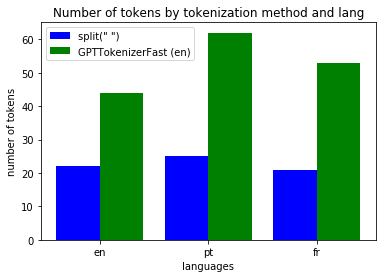

In [39]:
# graph "Number of tokens by tokenization method and lang"
# source: https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
text_split = list()
toks_split = list()

for text in texts:
    text_split.append(len(text.split()))
    toks_ids = tokenizer_en.encode(text)
    toks_split.append(len(toks_ids))
    
labels = langs
xy = list(np.array([1.,2.,3.]) - 0.2)
xz = list(np.array([1.,2.,3.]) + 0.2)
y = text_split
z = toks_split

ax = plt.subplot(111)
ax.bar(xy, y, width=0.4, color='b', align='center')
ax.bar(xz, z, width=0.4, color='g', align='center')

ax.set_xlabel('languages')
ax.set_xticks(range(1,len(labels)+1))
ax.set_xticklabels(labels)
ax.set_ylabel('number of tokens')
ax.legend(['split(" ")', 'GPTTokenizerFast (en)'])

ax.set_title('Number of tokens by tokenization method and lang')

plt.show()

As we can see, **even if a GPT2TokenizerFast trained with an English corpus can tokenize any text in any language, it was optimized for English**: the number of generated tokens is lower for an English text than for the same text in another language with an equivalent number of words.

In our example, 
- English: 44 tokens (22 words)
- French: 20% more tokens with 53 (21 words)
- Portuguese: 40% more tokens with 62 (25 words)

## English vs Portuguese tokenizer on Portuguese Wikipedia

In this paragraph, we will compare the number of tokens per Portuguese text generated respectively by the English and Portuguese tokenizers.

In [15]:
lang = 'pt'
fname = f'all_texts_{lang}wiki.csv'
df = pd.read_csv(path_data/fname)
df.head()

,text
0,"Fotografia (do grego φως [""fós""] (""luz""), e γραφις [""grafis""] (""estilo"", ""pincel"") ou γραφη ""grafê"", e significa ""desenhar com luz e contraste""), por definição, é essencialmente a ""técnica de criação"" de imagens por meio de exposição luminosa, fixando-as em uma superfície sensível. A primeira fotografia reconhecida remonta ao ano de 1826 e é atribuída ao francês Joseph Nicéphore Niépce. Contudo, a invenção da fotografia não é obra de um só autor, mas um processo de acúmulo de avanços por parte de muitas pessoas, trabalhando, juntas ou em paralelo, ao longo de muitos anos. Se por um lado os..."
1,"Espadanedo é uma antiga freguesia portuguesa do concelho de Macedo de Cavaleiros, com 17,90 km² de área e 188 habitantes (2011). A sua densidade populacional era 10,5 hab/km².\nFoi extinta (agregada) pela reorganização administrativa de 2012/2013, sendo o seu território integrado na União de Freguesias de Espadanedo, Edroso, Murçós e Soutelo Mourisco.\n\nA antiga freguesia de S. Miguel de Espadanedo e Valongo pertenceu ao antigo concelho de Torre D. Chama, extinto a 24 de Outubro de 1855, em 1839 aparece agregada à comarca de Bragança e em 1852 à de Mirandela. Passa a pertencer definitivam..."
2,"Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo. O seu trabalho mais conhecido é, sem dúvida, o Panthéon (Panteão) de Paris, construído a partir de 1755, inicialmente uma igreja dedicada a Santa Genoveva.\n\nSoufflot nasceu em Irancy, perto de Auxerre, na França. Com 18 anos, entrou para a Academia Francesa de Roma, onde os jovens estudantes da década de 1750 se tornariam na primeira geração de criativos pleanamente neoclássicos. Ficará na Itália de 1731 a 1738. Quando volto..."
3,"A Faculdade de Medicina da Universidade de São Paulo (FMUSP) é uma escola médica da Universidade de São Paulo. Foi fundada em 1912 com o nome de ""Faculdade de Medicina e Cirurgia de São Paulo"" por Arnaldo Vieira de Carvalho (1867-1920), médico formado em 1888 pela Faculdade de Medicina do Rio de Janeiro. Em homenagem ao ilustre fundador, a Faculdade é, ainda hoje, chamada de a ""Casa de Arnaldo"" por seus alunos e ex-alunos. Em 1925 teve seu nome alterado para ""Faculdade de Medicina de São Paulo"" e em 1934, foi incorporada à recém-criada Universidade de São Paulo, passando a ter a atual desi..."
4,"A Escola do Teatro Bolshoi no Brasil é uma tradicional escola de balé existente na cidade de Joinville, no estado de Santa Catarina. Fundada em 2000, é a única filial do Teatro Bolshoi de Moscou e possui alunos de vários estados brasileiros. Tem como missão formar artistas cidadãos, promover e difundir a arte-educação.\n\nA instituição foi fundada em 15 de março de 2000, é a única filial do Teatro Bolshoi. \n\nUm orgulho para o Brasil e para Joinville, cidade sede. A Escola do Teatro Bolshoi no Brasil, com professores russos e brasileiros, forma bailarinos com a mesma precisão, técnica e q..."


In [16]:
%%time
df2 = df.copy()

tokens_en_list = list()
num_token_by_word_en_list = list()
tokens_pt_list = list()
num_token_by_word_pt_list = list()

for index, row in df2.iterrows():
    text = row['text']
    
    tokens_en = tokenizer_en.encode(text)
    tokens_pt = tokenizer_pt.encode(text)
    
    tokens_en_list.append(tokens_en)
    tokens_pt_list.append(tokens_pt)
    
    length_text = len(text.split())
    tokens_by_word_en = len(tokens_en)/length_text
    tokens_by_word_pt = len(tokens_pt)/length_text
    
    num_token_by_word_en_list.append(tokens_by_word_en)
    num_token_by_word_pt_list.append(tokens_by_word_pt)
    
df2['tokens_en'] = tokens_en_list
df2['num_token_by_word_en'] = num_token_by_word_en_list
df2['tokens_pt'] = tokens_pt_list
df2['num_token_by_word_pt'] = num_token_by_word_pt_list

CPU times: user 11h 46min 52s, sys: 2h 52min 55s, total: 14h 39min 48s
Wall time: 1h 32min 56s


In [17]:
df2.head()

,text,tokens_en,num_token_by_word_en,tokens_pt,num_token_by_word_pt
0,"Fotografia (do grego φως [""fós""] (""luz""), e γραφις [""grafis""] (""estilo"", ""pincel"") ou γραφη ""grafê"", e significa ""desenhar com luz e contraste""), por definição, é essencialmente a ""técnica de criação"" de imagens por meio de exposição luminosa, fixando-as em uma superfície sensível. A primeira fotografia reconhecida remonta ao ano de 1826 e é atribuída ao francês Joseph Nicéphore Niépce. Contudo, a invenção da fotografia não é obra de um só autor, mas um processo de acúmulo de avanços por parte de muitas pessoas, trabalhando, juntas ou em paralelo, ao longo de muitos anos. Se por um lado os...","[37, 313, 519, 32188, 544, 357, 4598, 10536, 2188, 18074, 228, 49535, 35558, 14631, 69, 10205, 82, 8973, 5855, 2290, 89, 12340, 304, 7377, 111, 33643, 17394, 139, 228, 29945, 35558, 14631, 70, 32188, 271, 8973, 5855, 395, 18526, 1600, 366, 79, 924, 75, 4943, 267, 84, 7377, 111, 33643, 17394, 139, 228, 138, 115, 366, 70, 32188, 25792, 1600, 304, 2216, 64, 366, 8906, 268, 9869, 401, 300, 10277, 304, 3445, 4594, 12340, 16964, 2730, 72, 16175, 28749, 11, 38251, 3209, 268, 2413, 434, 68, 257, 366, 83, 2634, 31522, 3970, 390, 269, 7496, 16175, 28749, 1, 390, 3590, ...]",2.369519,"[9493, 22419, 363, 360, 5712, 46504, 30015, 16691, 33769, 70, 592, 32642, 1293, 21146, 2301, 258, 6970, 112, 17273, 12320, 46645, 17472, 16691, 33769, 4700, 274, 32642, 1293, 38371, 474, 330, 6701, 1996, 1766, 414, 6970, 112, 17273, 12320, 46645, 29825, 330, 4700, 369, 474, 258, 1952, 330, 1202, 1308, 290, 297, 3551, 258, 9592, 2301, 358, 5758, 12, 372, 9420, 259, 330, 38735, 260, 2271, 2, 260, 4318, 358, 1513, 260, 5214, 36162, 12, 34567, 13, 267, 300, 349, 4144, 17706, 14, 315, 806, 9659, 8892, 13110, 443, 750, 260, 22051, 258, 372, 11679, 443, 3081, 7358, 5227, 293, ...]",1.295616
1,"Espadanedo é uma antiga freguesia portuguesa do concelho de Macedo de Cavaleiros, com 17,90 km² de área e 188 habitantes (2011). A sua densidade populacional era 10,5 hab/km².\nFoi extinta (agregada) pela reorganização administrativa de 2012/2013, sendo o seu território integrado na União de Freguesias de Espadanedo, Edroso, Murçós e Soutelo Mourisco.\n\nA antiga freguesia de S. Miguel de Espadanedo e Valongo pertenceu ao antigo concelho de Torre D. Chama, extinto a 24 de Outubro de 1855, em 1839 aparece agregada à comarca de Bragança e em 1852 à de Mirandela. Passa a pertencer definitivam...","[36, 2777, 324, 22739, 78, 38251, 334, 2611, 1885, 13827, 2030, 70, 947, 544, 2493, 1018, 947, 64, 466, 369, 5276, 8873, 390, 25942, 78, 390, 19931, 1000, 72, 4951, 11, 401, 1596, 11, 3829, 1849, 13276, 31185, 390, 6184, 94, 21468, 304, 27778, 7947, 39781, 357, 9804, 737, 317, 424, 64, 29509, 312, 671, 16595, 330, 1538, 6980, 838, 11, 20, 387, 65, 14, 13276, 31185, 13, 198, 37, 23013, 1070, 600, 64, 357, 363, 2301, 4763, 8, 279, 10304, 35459, 23638, 16175, 28749, 6863, 265, 12151, 390, 2321, 14, 6390, 11, 3758, 78, 267, 384, 84, 5771, 10205, ...]",2.392857,"[1438, 15237, 1388, 360, 372, 349, 2661, 4766, 3764, 298, 5975, 260, 16023, 260, 19537, 12, 297, 1115, 12, 5699, 638, 2107, 4490, 260, 1430, 258, 2731, 2668, 363, 9381, 609, 315, 450, 7173, 9342, 621, 1194, 12, 21, 8770, 15, 2107, 4490, 14, 199, 2704, 10602, 363, 599, 45513, 9, 534, 19571, 8497, 260, 1762, 15, 11825, 12, 790, 275, 467, 2521, 11558, 347, 2743, 260, 40439, 260, 3158, 271, 1388, 360, 12, 2088, 6129, 12, 6834, 286, 592, 258, 2582, 3026, 6713, 1141, 423, 14, 199, 199, 33, 2661, 4766, 260, 327, 14, 4379, 260, 3158, 271, 1388, ...]",1.486264
2,"Jacques-Germain Soufflot (Irancy, 22 de julho de 1713 — Paris, 29 de agosto de 1780) foi um arquitecto francês, iniciador do estilo arquitectónico do Neoclassicismo. O seu trabalho mais conhecido é, sem dúvida, o Panthéon (Panteão) de Paris, construído a partir de 1755, inicialmente uma igreja dedicada a Santa Genoveva.\n\nSoufflot nasceu em Irancy, perto de Auxerre, na França. Com 18 anos, entrou para a A

In [18]:
# save
fname = "comparaison_tokenizers_en_pt_with_corpus_pt.csv"
df2.to_csv(path_data/fname, index=False)

In [19]:
# load
fname = "comparaison_tokenizers_en_pt_with_corpus_pt.csv"
df2 = pd.read_csv(path_data/fname)

In [41]:
# check min
num_token_by_word_en_min = df2.num_token_by_word_en.min()
num_token_by_word_pt_min = df2.num_token_by_word_pt.min()
print('(en)',round(num_token_by_word_en_min,2))
print('(pt)',round(num_token_by_word_pt_min,2))

(en) 1.31
(pt) 1.12


In [42]:
# check max
num_token_by_word_en_max = df2.num_token_by_word_en.max()
num_token_by_word_pt_max = df2.num_token_by_word_pt.max()
print('(en)',round(num_token_by_word_en_max,2))
print('(pt)',round(num_token_by_word_pt_max,2))

(en) 75.29
(pt) 75.65


In [43]:
# check mean
num_token_by_word_en_mean = df2.num_token_by_word_en.mean()
num_token_by_word_pt_mean = df2.num_token_by_word_pt.mean()
print('(en)',round(num_token_by_word_en_mean,2))
print('(pt)',round(num_token_by_word_pt_mean,2))

(en) 2.25
(pt) 1.36


In [38]:
# check increase rate and Multiplier coefficient
increase = 0.
multiplier = 0.

for tok_en,tok_pt in zip(*(tokens_en_list,tokens_pt_list)):
    increase += (len(tok_en)-len(tok_pt))/len(tok_pt)
    multiplier += len(tok_en)/len(tok_pt)
    
# Rate of increase in % from pt to en
increase_pct = increase / len(tokens_en_list)
print('Rate of increase:',round(increase_pct*100,2),'%')

# Multiplier coefficient = (Rate of increase in %, converted to number) + 1
multiplier_coef = round(increase_pct+1,2)
print('Multiplier coefficient:',multiplier_coef)

# Multiplier coefficient in % = Multiplier coefficient, converted to %
multiplier_pct = round((multiplier/len(tokens_en_list))*100,2)
print('Multiplier coefficient in %:',multiplier_pct,'%')

Rate of increase: 65.87 %
Multiplier coefficient: 1.66
Multiplier coefficient in %: 165.87 %


### Graph

In [26]:
%%time
len_tokens_text_list = list()
for index, row in df2.iterrows():
    text = row['text']
    length_text = len(text.split())
    len_tokens_text_list.append(length_text)

tokens_en_list = df2.tokens_en.tolist()
len_tokens_en_list = [len(t) for t in tokens_en_list]

tokens_pt_list = df2.tokens_pt.tolist()
len_tokens_pt_list = [len(t) for t in tokens_pt_list]

CPU times: user 1min 51s, sys: 1.63 s, total: 1min 53s
Wall time: 1min 53s


/mnt/home/pierre/.conda/envs/fastai2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


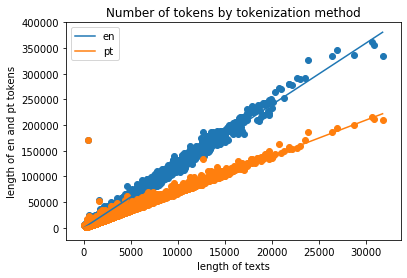

In [27]:
sorted_len_tokens_text_list = sorted(len_tokens_text_list)
y_len_tokens_en_list = (12*np.array(sorted_len_tokens_text_list)).tolist() 
y_len_tokens_pt_list = (7*np.array(sorted_len_tokens_text_list)).tolist()                             

ax = plt.subplot(111)
ax.scatter(len_tokens_text_list, len_tokens_en_list)
ax.plot(sorted_len_tokens_text_list, y_len_tokens_en_list)
ax.scatter(len_tokens_text_list, len_tokens_pt_list)
ax.plot(sorted_len_tokens_text_list, y_len_tokens_pt_list)

ax.set_xlabel('length of texts')
ax.set_ylabel('length of en and pt tokens')
ax.legend(['en', 'pt'])

ax.set_title('Number of tokens by tokenization method')

plt.show()

As we can see, the use of a BBPE tokenizer trained with an English corpus on a corpus of another language (here, Portuguese) **requires on average almost 70% of additional tokens** (66% exactly) than a BBPE tokenizer trained with the same language of the corpus of application.

## END